L'objectif de ce notebook est de rassembler différentes méthodes de pré-traitement des données avec la gestion des valeurs nulles.
Les algorithmes étudiés sont les suivants :

- Imputation (par la moyenne par jour sur chaque parcelle)
- Interpolation
- K-nearest neighbors reconstruction

In [ ]:
# Attention : prend 2 minutes
!gdown https://drive.google.com/uc?id=1emmjcpCKDOWQoS2ZL6ZLcSIxNgUBQmOh -O USE_CASE_1.zip

Downloading...
From: https://drive.google.com/uc?id=1emmjcpCKDOWQoS2ZL6ZLcSIxNgUBQmOh
To: /content/USE_CASE_1.zip
100% 3.30G/3.30G [00:53<00:00, 81.5MB/s]


In [ ]:
#!unzip USE_CASE_1.zip


# Data Inspection, Preprocessing and Visualization
The objective of this notebook is to inspect the temporal statistics of each parcel, preprocess them and visualize some useful insights of the data. 

In [ ]:
#! pip install geopandas

In [ ]:
# ! pip install plotly==4.6.0

In [ ]:
import numpy as np
import os 
from os import listdir
from os.path import isfile,isdir,join
import geopandas as gpd
import pandas as pd
from datetime import datetime
import plotly.express as px # visualisation interactive
import plotly
import plotly.io as pio

# Load the geodataframe

In [ ]:
gdf_ndvi = gpd.read_file('./USE_CASE_1/temporal_stats_prof/temporal_stats_prof/T31TCJ_ndvi_median.shp')

In [ ]:
print(type(gdf_ndvi), '\n',
type(gdf_ndvi))

<class 'geopandas.geodataframe.GeoDataFrame'> 
 <class 'geopandas.geodataframe.GeoDataFrame'>


In [ ]:
print(gdf_ndvi.shape)

(5000, 75)


In [ ]:
print(gdf_ndvi)

            fid  ...                                           geometry
0     7918132.0  ...  POLYGON ((346100.728 4856718.116, 346101.164 4...
1     7109780.0  ...  POLYGON ((388836.372 4848383.454, 388836.586 4...
2     7021173.0  ...  POLYGON ((317915.388 4796580.085, 317910.352 4...
3     7891909.0  ...  POLYGON ((404297.751 4848228.615, 404328.793 4...
4      695973.0  ...  POLYGON ((393371.402 4844649.750, 393322.862 4...
...         ...  ...                                                ...
4995  7866928.0  ...  POLYGON ((397113.853 4863757.208, 397027.610 4...
4996  7043233.0  ...  POLYGON ((387932.813 4792953.502, 387932.935 4...
4997  7951143.0  ...  POLYGON ((338563.873 4851521.256, 338437.762 4...
4998  7219111.0  ...  POLYGON ((346429.267 4825369.919, 346427.730 4...
4999  7224943.0  ...  POLYGON ((332569.403 4812305.912, 332570.330 4...

[5000 rows x 75 columns]


In [ ]:
gdf_ndvi.iloc[:,0:5]

,fid,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP
0,7918132.0,8583490,2.71,MIS,2
1,7109780.0,14712598,2.60,MIS,2
2,7021173.0,12205360,5.57,MIS,2
3,7891909.0,16205895,5.00,MIS,2
4,695973.0,16183747,4.25,MIS,2
...,...,...,...,...,...
4995,7866928.0,16178895,2.50,BTH,1
4996,7043233.0,3150954,7.62,BTH,1
4997,7951143.0,8545608,6.90,BTH,1
4998,7219111.0,10062551,15.74,BTH,1


In [ ]:
gdf_ndvi.iloc[:,5:15]

,CULTURE_D1,CULTURE_D2,area,20181112,20181115,20181117,20181125,20181127,20181219,20190103
0,None,None,27085.062805,0.225880,NaN,0.402877,NaN,0.651829,NaN,NaN
1,None,None,25972.267365,0.305204,NaN,0.325589,NaN,0.366240,NaN,NaN
2,None,None,55591.881784,0.223748,NaN,0.237835,NaN,0.322333,NaN,NaN
3,None,None,49999.741512,0.165396,NaN,0.192027,NaN,0.201810,0.224843,0.304677
4,DFV,DVS,42492.768066,0.220622,NaN,0.248052,NaN,0.281957,0.436703,0.512927
...,...,...,...,...,...,...,...,...,...,...
4995,None,None,25009.197594,0.115875,NaN,0.146863,NaN,0.202459,0.370068,0.483932
4996,None,None,76108.772327,0.148536,NaN,0.208777,NaN,0.324335,0.662269,0.812591
4997,None,None,69007.675065,0.104522,NaN,0.162730,NaN,0.238011,NaN,NaN
4998,None,None,157208.368362,0.116782,NaN,0.118851,NaN,0.113749,NaN,NaN


## Count nans in each column in the geodataframe and create a dataframe where we count the number of nans for each date

In [ ]:
cols = gdf_ndvi.columns
cols

Index(['fid', 'ID_PARCEL', 'SURF_PARC', 'CODE_CULTU', 'CODE_GROUP',
       'CULTURE_D1', 'CULTURE_D2', 'area', '20181112', '20181115', '20181117',
       '20181125', '20181127', '20181219', '20190103', '20190109', '20190111',
       '20190116', '20190203', '20190212', '20190213', '20190215', '20190217',
       '20190218', '20190220', '20190222', '20190223', '20190225', '20190227',
       '20190320', '20190322', '20190324', '20190325', '20190327', '20190329',
       '20190330', '20190409', '20190413', '20190419', '20190501', '20190513',
       '20190514', '20190531', '20190602', '20190608', '20190617', '20190618',
       '20190627', '20190703', '20190705', '20190708', '20190710', '20190712',
       '20190713', '20190715', '20190723', '20190725', '20190802', '20190804',
       '20190809', '20190814', '20190816', '20190817', '20190822', '20190824',
       '20190906', '20190913', '20190915', '20190916', '20190920', '20190921',
       '20191008', '20191011', '20191013', 'geometry'],
      d

In [ ]:
# on selectionne les colonnes des dates seulement
np.isnan(gdf_ndvi[cols[8:-1]].values).sum()

205191

In [ ]:
205191/(gdf_ndvi.shape[0]*(gdf_ndvi.shape[1]-9))*100

62.1790909090909

In [ ]:
count_nan = gdf_ndvi[cols[8:-1]].isna().sum().values
count_not_nan = list(len(gdf_ndvi)-count_nan)
count_nan = list(count_nan)

# Selection des dates et reformater
dates = list(cols[8:-1])+list(cols[8:-1])
dates = [x[0:4]+'-'+x[4:6]+'-'+x[6:] for x in dates]
date = [datetime.strptime(x,'%Y-%m-%d') for x in dates]

counts = count_nan+count_not_nan
types = ['nan' for i in range (0,int(len(dates)/2))] + ['not_nan' for i in range (0,int(len(dates)/2))]  

In [ ]:
nan_df = pd.DataFrame(columns=['date','type','count'])
nan_df['date'] = dates
nan_df['type'] = types
nan_df['count'] = counts

In [ ]:
print(nan_df.loc[nan_df['type']=='nan'])

          date type  count
0   2018-11-12  nan    117
1   2018-11-15  nan   4956
2   2018-11-17  nan      1
3   2018-11-25  nan   4959
4   2018-11-27  nan    468
..         ...  ...    ...
61  2019-09-20  nan   4327
62  2019-09-21  nan   4940
63  2019-10-08  nan      0
64  2019-10-11  nan   4944
65  2019-10-13  nan     79

[66 rows x 3 columns]


In [ ]:
nan_df.loc[nan_df['date']=='2018-11-12']

,date,type,count
0,2018-11-12,nan,117
66,2018-11-12,not_nan,4883


## Use Plotly to create a bar plot. On the x-axis we have the dates and on the y-axis we have the counts of nans and not nans

In [ ]:
type(nan_df)

pandas.core.frame.DataFrame

In [ ]:
import plotly.express as px
fig = px.bar(nan_df, x="date", y="count", color="type", height=400, title="NaN distribution on dates")
fig.show()

In [ ]:
# nan_df.loc[nan_df.type=="not_nan"].sort_values("count", ascending=True).plot(kind='barh', figsize=(16, 30), y="count")

In [ ]:
test = nan_df.loc[nan_df.type=="not_nan"].sort_values("count", ascending=True)
test.head()

,date,type,count
69,2018-11-25,not_nan,41
67,2018-11-15,not_nan,44
123,2019-09-06,not_nan,44
113,2019-07-23,not_nan,45
120,2019-08-17,not_nan,45


In [ ]:
test = nan_df.loc[nan_df.type=="nan"].sort_values("count", ascending=True)
test.head()

,date,type,count
46,2019-07-15,nan,0
63,2019-10-08,nan,0
50,2019-08-04,nan,0
48,2019-07-25,nan,0
22,2019-03-22,nan,0


## Get dates that have more than 60% of missing data and drop them from the geodataframe

In [ ]:
tmp_df = nan_df.loc[(nan_df['type']=='nan')]
dates = tmp_df.loc[tmp_df['count']>=int(0.6*len(gdf_ndvi))]['date']
dates = [''.join(x.split('-')) for x in dates]

In [ ]:
# on garde uniquement les dates pour les quelles le nb de valeur nulle est inférieur à 3000=0.6*len(gdf_ndvi)
cleaned_gdf = gdf_ndvi.drop(dates,axis=1)
cleaned_cols = cleaned_gdf.columns

In [ ]:
cleaned_cols

Index(['fid', 'ID_PARCEL', 'SURF_PARC', 'CODE_CULTU', 'CODE_GROUP',
       'CULTURE_D1', 'CULTURE_D2', 'area', '20181112', '20181117', '20181127',
       '20190111', '20190116', '20190215', '20190220', '20190225', '20190322',
       '20190327', '20190501', '20190531', '20190705', '20190710', '20190715',
       '20190725', '20190804', '20190809', '20190814', '20190824', '20190913',
       '20191008', '20191013', 'geometry'],
      dtype='object')

In [ ]:
np.isnan(cleaned_gdf[cleaned_cols[8:-1]].values).sum()

2956

In [ ]:
dates = list(cleaned_cols[8:-1].values)
dates = [x[0:4]+'-'+x[4:6]+'-'+x[6:] for x in dates]
date = [datetime.strptime(x,'%Y-%m-%d') for x in dates]
# index 3,6,,4988
y_missing = list(cleaned_gdf.iloc[3][cleaned_cols[8:-1]].values)

px.line(x=dates, y=y_missing)

In [ ]:
!mkdir ./etudiants/
!mkdir ./etudiants/name_surname/
!mkdir ./etudiants/name_surname/USE_CASE_1/
!mkdir ./etudiants/name_surname/USE_CASE_1/cleaned_stats/

In [ ]:
cleaned_stats = '/etudiants/name_surname/USE_CASE_1/cleaned_stats/T31TCJ_median_ndvi.shp'
#cleaned_gdf.to_file(cleaned_stats_test)

In [ ]:
ls ./USE_CASE_1/cleaned_stats/cleaned_stats/

T31TCJ_median_ndvi.cpg  T31TCJ_median_ndvi.prj  T31TCJ_median_ndvi.shx
T31TCJ_median_ndvi.dbf  T31TCJ_median_ndvi.shp


# Exercice
## Missing data interpolation with Geopandas

A partir du tableau `cleaned_gdf` appliquer une interpolation linéaire afin d'estimer les valeurs manquantes. 

Rechercher la fonction dans la librairie `Geopandas`de Python.


In [ ]:
## A vous de jouer !

### Une correction

In [ ]:
cleaned_gdf.iloc[50,:]

fid                                                 7.90292e+06
ID_PARCEL                                              13665700
SURF_PARC                                                 12.19
CODE_CULTU                                                  MIS
CODE_GROUP                                                    2
CULTURE_D1                                                 None
CULTURE_D2                                                 None
area                                                     121857
20181112                                               0.223982
20181117                                               0.208718
20181127                                                    NaN
20190111                                               0.105782
20190116                                               0.343049
20190215                                              0.0829443
20190220                                               0.100351
20190225                                

In [ ]:
interpolated_gdf = cleaned_gdf.copy()
interpolated_gdf[cleaned_cols[8:-1]] = interpolated_gdf[cleaned_cols[8:-1]].interpolate()

In [ ]:
interpolated_gdf.iloc[50,:]

fid                                                 7.90292e+06
ID_PARCEL                                              13665700
SURF_PARC                                                 12.19
CODE_CULTU                                                  MIS
CODE_GROUP                                                    2
CULTURE_D1                                                 None
CULTURE_D2                                                 None
area                                                     121857
20181112                                               0.223982
20181117                                               0.208718
20181127                                               0.299223
20190111                                               0.105782
20190116                                               0.343049
20190215                                              0.0829443
20190220                                               0.100351
20190225                                

In [ ]:
np.isnan(interpolated_gdf[cleaned_cols[8:-1]].values).sum()

0

In [ ]:
# idx = 4988
y_missing = list(cleaned_gdf.iloc[6][cleaned_cols[8:-1]].values)
y_interpolated =list(interpolated_gdf.iloc[6][cleaned_cols[8:-1]].values)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Scatter(
     x=dates,
     y=y_missing,
     name='missing data',
     marker=dict(
         color='blue'
               ),
     mode = 'lines')
trace2 = go.Scatter(
     x=dates,
     y=y_interpolated,
     name='filled data',
     marker=dict(
         color='red'
               ),
     mode = 'lines')

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 600, width = 1000)
fig

# Une méthode gagnante
## Missing data reconstruction with KNN
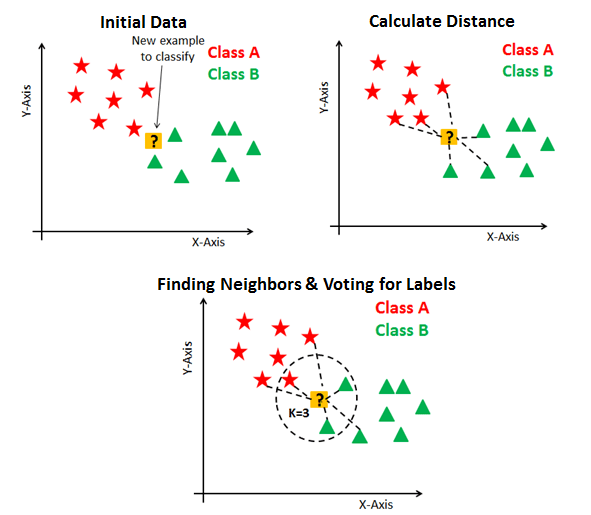

In [ ]:
import numpy as np
from six.moves import range

def pair_n_distance(X):
    n_rows, n_cols = X.shape
    D = np.ones((n_rows, n_rows), dtype="float32", order="C") * np.inf
    observed_features = np.isfinite(X).astype(int)
    n_common_features_observations = np.dot(observed_features,observed_features.T)
    actual_n_common_features = n_common_features_observations == 0
    n_no_common_observations = actual_n_common_features.sum(axis=1)
    observation_overlaps_all = (n_no_common_observations == 0)
    observation_overlaps_non = n_no_common_observations == n_rows
    diffs = np.zeros_like(X)
    missing_differences = np.zeros_like(diffs, dtype=bool)
    valid_observations = np.zeros(n_rows, dtype=bool)
    ssd = np.zeros(n_rows, dtype=X.dtype)

    for i in range(n_rows):
        if observation_overlaps_non[i]:
            continue
        x = X[i, :]
        np.subtract(X, x.reshape((1, n_cols)), out=diffs)
        np.isnan(diffs, out=missing_differences)
        diffs[missing_differences] = 0
        diffs **= 2
        observed_counts_per_observation = n_common_features_observations[i]
        if observation_overlaps_all[i]:
            diffs.sum(axis=1, out=D[i, :])
            D[i, :] /= observed_counts_per_observation
        else:
            np.logical_not(actual_n_common_features[i], out=valid_observations)
            diffs.sum(axis=1, out=ssd)
            ssd[valid_observations] /= observed_counts_per_observation[valid_observations]
            D[i, valid_observations] = ssd[valid_observations]
    return D

def init_knn(X, missing_mask):
    X_input = X.copy("C")
    if missing_mask.sum() != np.isnan(X_input).sum(): 
        X_input[missing_mask] = np.nan
    D = pair_n_distance(X_input)
    for i in range(X.shape[0]):
        D[i, i] = np.inf
    return X_input, D

def knn_reconstruct(X,missing_mask,k):
    n_rows, n_cols = X.shape
    X_output, D = init_knn(X, missing_mask)
    fin_distance_mask = np.isfinite(D)
    eff_inf = 10 ** 6 * D[fin_distance_mask].max()
    D[~fin_distance_mask] = eff_inf
    for i in range(n_rows):
        for j in np.where(missing_mask[i, :])[0]:
            distances = D[i, :].copy()
            distances[missing_mask[:, j]] = eff_inf
            ind_neighbors = np.argsort(distances)
            dist_neighbors = distances[ind_neighbors]
            valid_distances = dist_neighbors < eff_inf
            dist_neighbors = dist_neighbors[valid_distances][:k]
            ind_neighbors = ind_neighbors[valid_distances][:k]
            weights = 1.0 / dist_neighbors
            weight_sum = weights.sum()
            if weight_sum > 0:
                column = X[:, j]
                values = column[ind_neighbors]
                X_output[i, j] = np.dot(values, weights) / weight_sum
    return X_output

In [ ]:
reconstructed_gdf = cleaned_gdf.copy()
data_arr = reconstructed_gdf[cleaned_cols[8:-1]].values
missing_mask = np.isnan(data_arr)
rec_arr = knn_reconstruct(data_arr,missing_mask,5) # on choisit les 5 plus proches voisins
reconstructed_gdf[cleaned_cols[8:-1]] = np.copy(rec_arr)

In [ ]:
# Save data as a geodataframe
#reconstructed_stats = '/USE_CASE_1/reconstructed_stats/reconstructed_stats/T31TCJ_median_ndvi.shp'
#reconstructed_gdf.to_file(reconstructed_stats_test)

In [ ]:
idx = 6
y_missing = list(cleaned_gdf.iloc[idx][cleaned_cols[8:-1]].values)
y_interpolated =list(interpolated_gdf.iloc[idx][cleaned_cols[8:-1]].values)
y_reconstructed = list(reconstructed_gdf.iloc[idx][cleaned_cols[8:-1]].values)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Scatter(
     x=dates,
     y=y_missing,
     name='missing data',
     marker=dict(
         color='blue'
               ),
     mode = 'lines'
)
trace2 = go.Scatter(
     x=dates,
     y=y_interpolated,
     name='Interpolation',
     marker=dict(
         color='red'
               ),
     mode = 'lines'
)

trace3 = go.Scatter(
     x=dates,
     y=y_reconstructed,
     name='KNN',
     marker=dict(
         color='green'
               ),
     mode = 'lines'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig.add_trace(trace3,secondary_y=True)
fig['layout'].update(height = 600, width = 1000)
fig

## Reconstructed data histogram
Groupe 1 = le blé (en été l'indice est élevée)

Groupe 2 = le mais

Visualisation la différence entre les différentes parcelles agricoles selon leur indicateur de réflectance mesuré depuis les satellites et ensuite transformées et préparées avec des méthodes statistiques.

In [ ]:
import plotly.express as px
fig = px.histogram(reconstructed_gdf, x="20190327",color='CODE_GROUP', nbins=10)
fig.show()

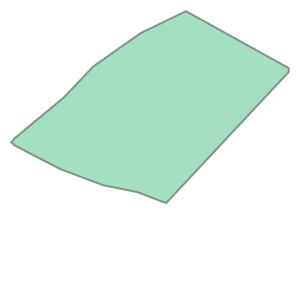

In [ ]:
interpolated_gdf.iloc[2]['geometry']

## Plot shapefile but first of all we need to save it as a geojson

In [ ]:
interpolated_gdf.to_crs(epsg=4326, inplace=True)
interpolated_gdf = interpolated_gdf.sample(frac=1).reset_index(drop=True)

interpolated_stats = './USE_CASE_1/interpolated_stats/interpolated_stats/T31TCJ_median_ndvi_interpolation.geojson'

#interpolated_gdf.to_file(interpolated_stats_test, driver='GeoJSON')

In [ ]:
!ls ./USE_CASE_1/interpolated_stats/interpolated_stats

T31TCJ_median_ndvi_interpolation.geojson


In [ ]:
import json
with open(interpolated_stats) as f:
    parcels = json.load(f)

In [ ]:
type(parcels)

dict

In [ ]:
# ATTENTION : ne pas RUN car "Output is truncated to 10240000 bytes. Learn more about ZEPPELIN_INTERPRETER_OUTPUT_LIMIT"
#parcels

In [ ]:
parcels["features"][0]['geometry']['coordinates'][0][0]

[1.703789969611079, 43.74291799165089]

In [ ]:
parcels['features'][0]['properties']

{'20181112': 0.627188444137573,
 '20181117': 0.693202674388885,
 '20181127': 0.768735349178314,
 '20190111': 0.884026825428009,
 '20190116': 0.889785587787628,
 '20190215': 0.878061234951019,
 '20190220': 0.853235483169556,
 '20190225': 0.822463750839233,
 '20190322': 0.306007385253906,
 '20190327': 0.291744828224182,
 '20190501': 0.136518776416779,
 '20190531': 0.212037354707718,
 '20190705': 0.692834436893463,
 '20190710': 0.840384602546692,
 '20190715': 0.846856653690338,
 '20190725': 0.775652170181274,
 '20190804': 0.811909675598145,
 '20190809': 0.819494605064392,
 '20190814': 0.847047865390778,
 '20190824': 0.754042148590088,
 '20190913': 0.588805139064789,
 '20191008': 0.431200712919235,
 '20191013': 0.31086853146553,
 'CODE_CULTU': 'MIS',
 'CODE_GROUP': '2',
 'CULTURE_D1': None,
 'CULTURE_D2': None,
 'ID_PARCEL': '16170710',
 'SURF_PARC': 6.5,
 'area': 64949.93502475352,
 'fid': 7859329.0}